# Introduction into System Dynamics using Python

System dynamics is a method devoted to the study of systems, and is thus a tool within the Systems Thinking tool kit. It uses simple graphical notations to model systems such as stock and flow diagrams. These diagrams contain specific components and symbols to describe systems. This tutorial gives an introduction to the elemens of stock and flow diagram using the BPTK-Py framework.

The tutorial explains system dynamics with a population model. The model shows how the population changes overtime and which factors influence the population value.

![Image](./images/population.png)


Now, let's create the model. It is used to store all stocks, converters and flows. The model runs for 10 years (starttime = 0, stoptime = 10) and we want to analyse the results after each year (dt = 1). In the next steps we are going to add the stocks and flows to the model.

We want to simulate how the population changes in the next ten years under external influences.

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

model = Model(starttime=1.0,stoptime=10.0,dt=1.0,name='Population')

### Stocks

A stock represents a part of a system whose value at any given instant in time depends on the systems past behavior. The value of the stocks at a particular instant in time cannot simply be determined by measuring the value of the other parts of the system at that instant in time – the only way you can calculate it is by measuring how it changes at every instant and adding up all these changes.

![Image](./images/stock_population.png)

The stock in our model represents the population at each timestep. Initially, we assume 80 mio. people living in our fictional country.  We create a model by entering `model.stock(<name>)`. The name of our stock is "population".


In [2]:
population = model.stock("population")
population.initial_value = 80000000.0

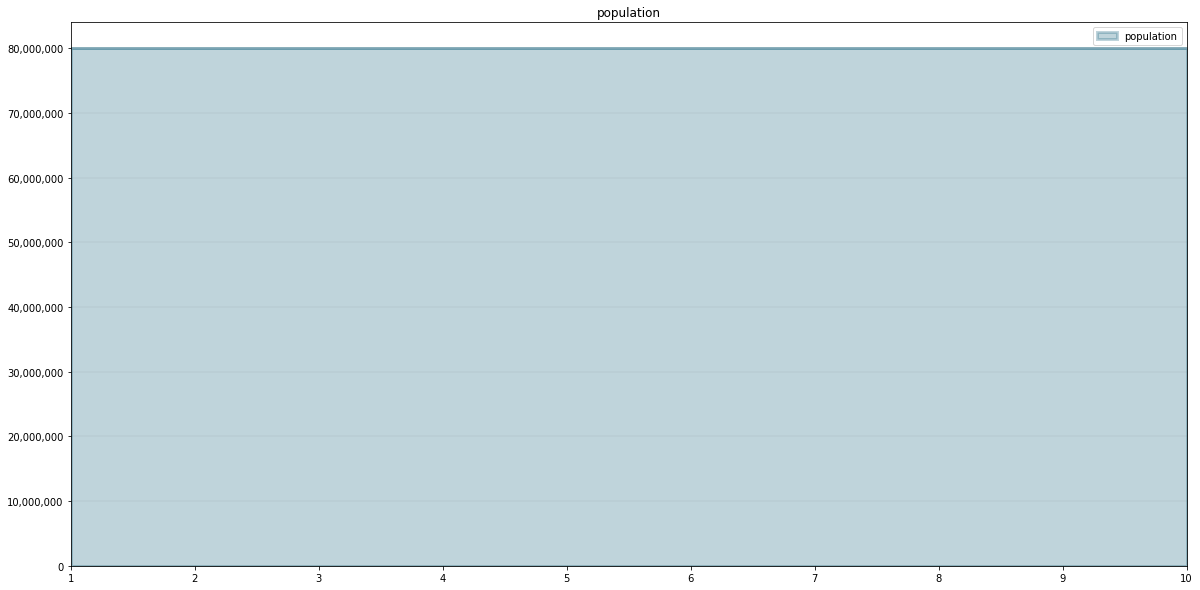

In [3]:
population.plot()

The population does not change. There are no other factors influencing the number of people. To simulate changes in the population, we need births and deaths. We add these factors by using flows.

### Flows

Flows represent the rate at which the stock is changing at any given timestep. They either flow into a stock (causing it to increase) or flow out of a stock (causing it to decrease).

![Image](./images/flow_births.png) ![Image](./images/flow_deaths.png)

Let us make this model simple and just suppose 1,000,000 babies are born and 2,000,000 people die each year. The flows are defined by using the method `model.flow(<name>)`.

In [4]:
births = model.flow("births")
deaths = model.flow("deaths")
births.equation = 1000000.0
deaths.equation = 2000000.0

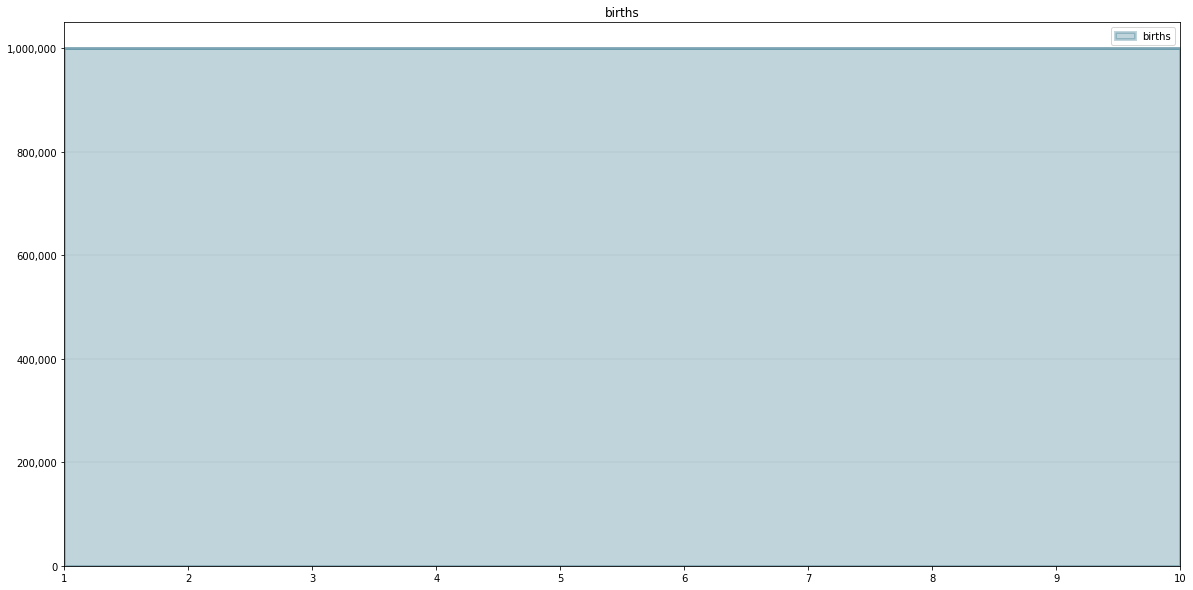

In [5]:
births.plot()

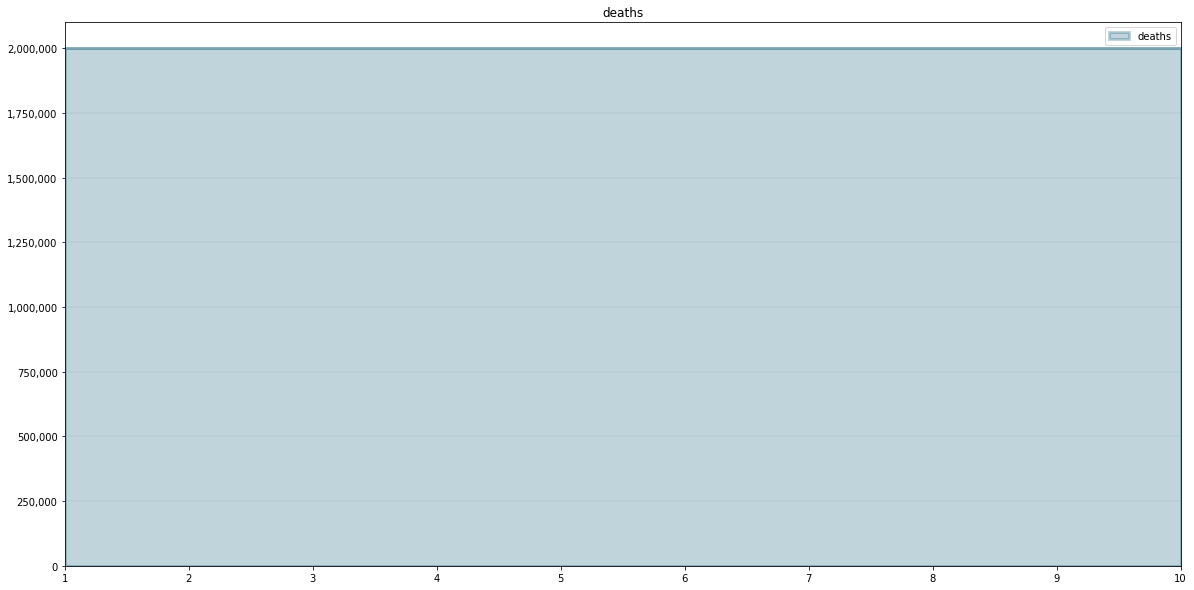

In [6]:
deaths.plot()

### Equations

To connect elements we require equations. These are mathematical operations that are evaluated at each timestep. We combine the flows with our stock by setting the ``equation`` field of ``population``.

![Image](./images/stock_flow_population.png)

In our simple example, the population is the sum of births minus the deaths plus the initial value or the value from the last timestep.

The Logic in System Dynamics is always the same: Values at timestep ``t`` depend on the result at ``t-1`` Let us look at the population:
```

population.equation = births - deaths

population (1)  = 80,000,0000 (start time)
population (2) = population(1) + (births(2) - deaths(2)) = 80,000,000 + (1,000,000 - 2,000,000) = 79,000,000
population (3) = population(2) + (births(2) - deaths(2)) = 79,000,000 + (1,000,000 - 2,000,000) = 78,000,000

and so on...
```

See how easy it is to define this behavior:

In [7]:
population.equation = births - deaths

And let's check whether we are able to obtain the expected results:

In [8]:
print("population(1): " + str(population(1)))
print("population(2): " + str(population(2)))
print("population(3): " + str(population(3)))


population(1): 80000000.0
population(2): 79000000.0
population(3): 78000000.0


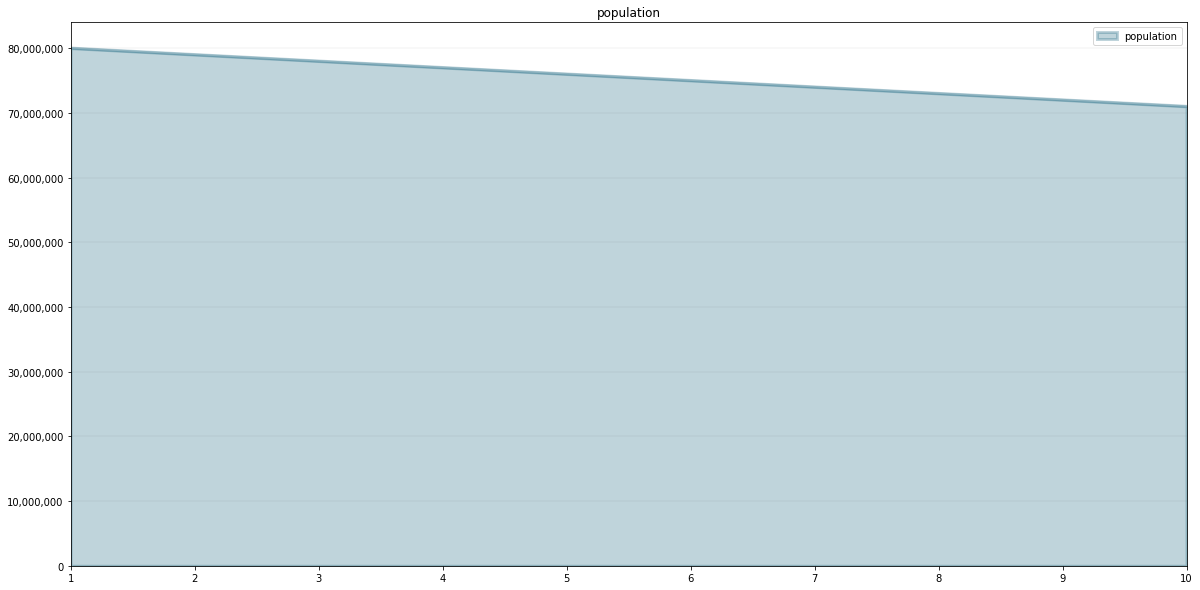

In [9]:
population.plot()

In reality, the number of births or deaths is not fixed, we usually work with ratios. They change depending on the population and external factors (diseases, medical supply, food supply etc.). In system dynamics, we model such behavior with converters. 

### Converters

Converters either represent parts at the boundary of the system (i.e. parts whose value is not determined by the behaviour of the system itself) or they represent parts of a system whose value can be derived from other parts of the system at any time through some computational procedure.

Let us model the following model in Python

![Image](./images/population.png)

In the image above, the converters are represented by circles. In Python, we define converters with ``model.converter`` or ``model.constant``. ``constants`` are converters with a constant value (i.e. they never change).

We want to model the birth rate and death rate that are influenced by the food supply.

In [10]:
birthRate = model.converter("birthRate")
deathRate = model.converter("deathRate")
foodAvailablePerPerson = model.converter("foodAvailablePerPerson")
foodAvailable = model.constant("foodAvailable")

### Connectors 

Much like in causal loop diagrams the connectors of a system show how the parts of a system influence each other.  Stocks can only be influenced by flows (i.e. there can be no connector that connects into a stock), flows can be influenced by stocks, other flows, and by converters. Converters either are not influenced at all (i.e. they are at the systems boundary) or are influenced by stocks, flows and other converters.

Please note that we do not explicitly model connectors but create the connection by defining equations. Equations are expressive enough to represent interactions between model elements.

Since `foodAvailable` is a constant, we can initiliaze it with a float value.

In [11]:
foodAvailable.equation = 80000000.0

The converters `foodAvailablePerPerson` and `birthRate` are formulas. `foodAvailablePerPerson` depends on `population` and `foodAvailable`. The more people the less food per person. The birth rate decreases if we have less than one unit food per person.

In [12]:
foodAvailablePerPerson.equation = foodAvailable / population

birthRate.equation = 0.01 * foodAvailablePerPerson

births.equation = birthRate * population

We define the death rate in our model using a non-linear relationship (depending on food available per person). We capture this relationship in a lookup table (often also called "graphical function" in the System Dynamics context) that we store in the `points` property of the model (using a Python list).

In [13]:
model.points["deathRate"] = [
    [0.0,1.0],
    [0.1,0.670320046036],
    [0.2,0.449328964117],
    [0.3,0.301194211912],
    [0.4,0.201896517995],
    [0.5,0.135335283237],
    [0.6,0.0907179532894],
    [0.7,0.0608100626252],
    [0.8,0.0407622039784],
    [0.9,0.0273237224473],
    [1.0,0.0183156388887]
]

deaths.equation = deathRate * population

We can easily plot the lookup table to see whether it has the right shape:

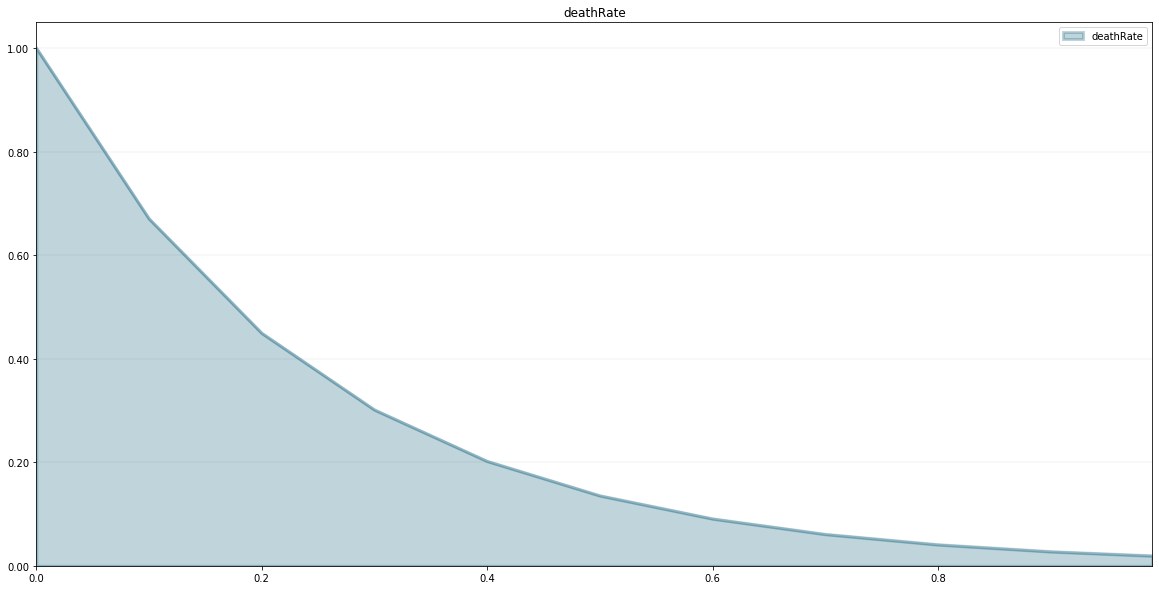

In [14]:
model.plot_lookup("deathRate")

Now, we have defined all components. Let us plot them. We first register the model.

In [15]:
import BPTK_Py
bptk = BPTK_Py.bptk()
bptk.register_model(model)

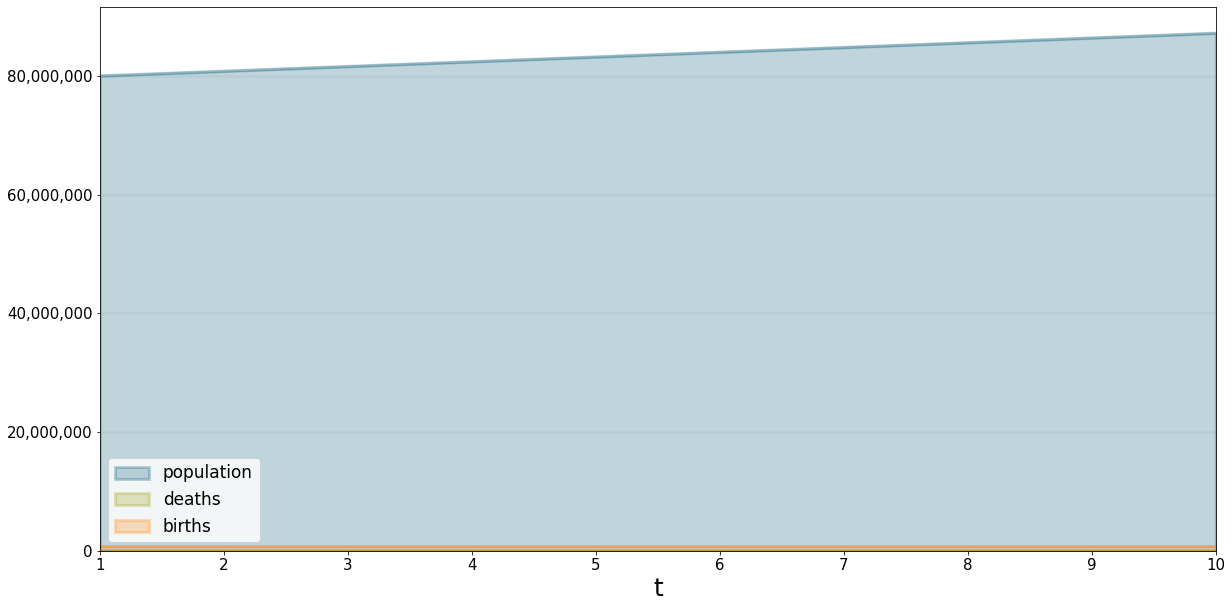

In [16]:
bptk.plot_scenarios(
    scenarios="base",
    scenario_managers="smPopulation",
    equations=["population","deaths","births"])

### Scenarios

BPTK Py creates a scenario `base` by default when registering the model. However, it is boring just to examine one scenario. We want to make various assumptions to understand the behavior of the model or the system. Changing values can lead to different outcomes. For this purpose, the BPTK Py framework provides a powerful scenario management enabling us to create different scenarios.

We set up a scenario manager using a Python dictionary. The scenario manager identifies the baseline constants of the model:

In [17]:
scenario_manager = {
    "smPopulation":{
        "model": model,
        "base_constants": {
        "population": 80000000.0,
        "foodAvailable": 80000000.0
        },
        "base_points":{
          "deathRate": [
            [0.0,1.0],
            [0.1,0.670320046036],
            [0.2,0.449328964117],
            [0.3,0.301194211912],
            [0.4,0.201896517995],
            [0.5,0.135335283237],
            [0.6,0.0907179532894],
            [0.7,0.0608100626252],
            [0.8,0.0407622039784],
            [0.9,0.0273237224473],
            [1.0,0.0183156388887]]
        }
    }
}

The scenario manager has to be registered as follows:

In [18]:
bptk.register_scenario_manager(scenario_manager)

After registering the scenario mangager, we can define and register more scenarios. Let us change `foodAvailable` from 80,000,000 units to 700,000 units.

In [19]:
bptk.register_scenarios(
    scenarios ={
        "scenario07": {
            "constants": {
                "foodAvailable": 700000.0,
            }
        }
    },
    scenario_manager="smPopulation")

Now, we can plot our scenarios `base` and `scenario07` and see how changing `foodAvailable` affects the population. We plot the `population` for both scenarios.

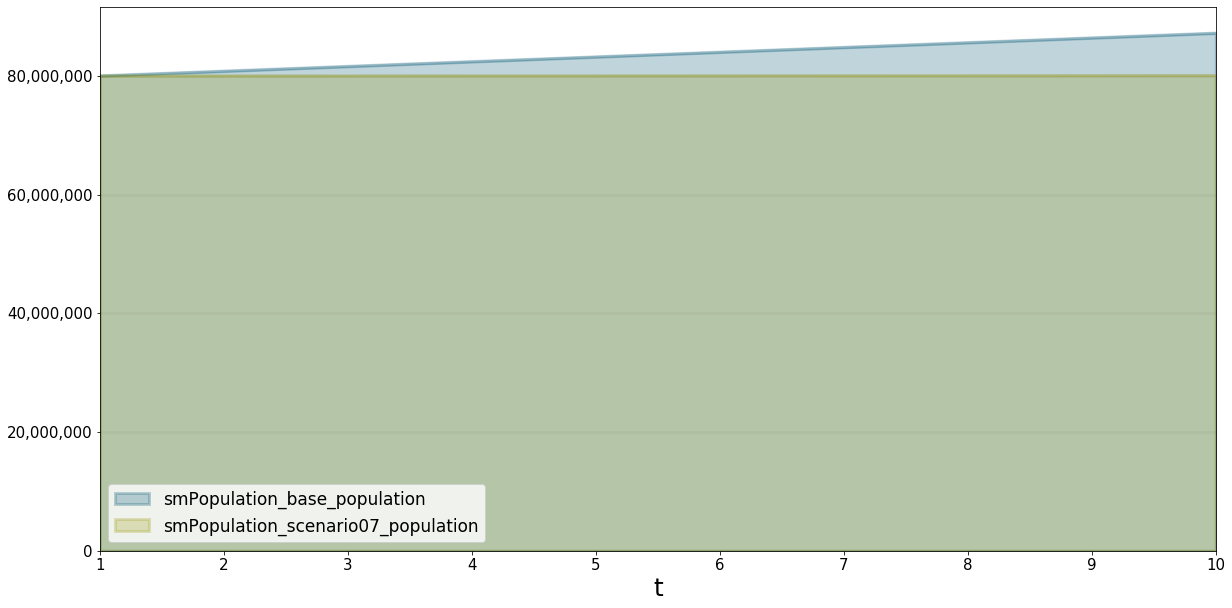

In [20]:
bptk.plot_scenarios(
    scenarios=["base","scenario07"],
    scenario_managers="smPopulation",
    equations=["population"],
    series_names={}
)

According to the stock and flow diagram `foodAvailable` influences `foodAvailablePerPerson`. The lesser food we have, the lesser food one person has. `foodAvailablePerPerson` then affects the births and deaths. Lesser people are born and more people die because we don't have enough food for each person. As a result, the population of `scenario07` increases slower than `base`.

## Export data as "DataFrame"

We built BPTK-Py with integration in mind. This means, you can easily export the simulation results as so-called "DataFrames". This is a standard Python exchange format for data. This means you can easily process the simulation results in other data analysis / data science packages for further processing (Machine Learning, Data enrichment and many more). Just add the argument ``return_df=True`` to the plot_scenarios call:

In [22]:
bptk.plot_scenarios(
    scenarios=["base","scenario07"],
    scenario_managers="smPopulation",
    equations=["population"], 
    series_names={},
    return_df=True)

,smPopulation_base_population,smPopulation_scenario07_population
t,,
1.0,80000000.0,80000000.0
2.0,80800000.0,80007000.0
3.0,81600000.0,80014000.0
4.0,82400000.0,80021000.0
5.0,83200000.0,80028000.0
6.0,84000000.0,80035000.0
7.0,84800000.0,80042000.0
8.0,85600000.0,80049000.0
9.0,86400000.0,80056000.0


Thanks for working this tutorial!